In [1]:
%matplotlib inline


Audio I/O
=========

``torchaudio`` integrates ``libsox`` and provides a rich set of audio I/O.


In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio boto3

import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


In [3]:
!pip install --upgrade boto3

Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [4]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.


import io
import os
import requests
import tarfile

import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
from IPython.display import Audio, display


_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"


def _fetch_data():
  os.makedirs(_SAMPLE_DIR, exist_ok=True)
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Quering audio metadata
----------------------

Function ``torchaudio.info`` fetches audio metadata. You can provide
a path-like object or file-like object.




In [5]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


Where

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

``encoding`` can take on one of the following values:

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, `Free Lossless Audio
   Codec <https://xiph.org/flac/>`__
-  ``"ULAW"``: Mu-law,
   [`wikipedia <https://en.wikipedia.org/wiki/%CE%9C-law_algorithm>`__]
-  ``"ALAW"``: A-law
   [`wikipedia <https://en.wikipedia.org/wiki/A-law_algorithm>`__]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [`xiph.org <https://xiph.org/vorbis/>`__]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec>`__]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband>`__]
-  ``"OPUS"``: Opus [`opus-codec.org <https://opus-codec.org/>`__]
-  ``"GSM"``: GSM-FR
   [`wikipedia <https://en.wikipedia.org/wiki/Full_Rate>`__]
-  ``"UNKNOWN"`` None of above




**Note**

-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as MP3).
-  ``num_frames`` can be ``0`` for GSM-FR format.




In [6]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=110559, num_channels=2, bits_per_sample=0, encoding=MP3)
AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


Querying file-like object
~~~~~~~~~~~~~~~~~~~~~~~~~

``info`` works on file-like objects.




In [7]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav
AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


**Note** When passing a file-like object, ``info`` does not read
all of the underlying data; rather, it reads only a portion
of the data from the beginning.
Therefore, for a given audio format, it may not be able to retrieve the
correct metadata, including the format itself.
The following example illustrates this.

-  Use argument ``format`` to specify the audio format of the input.
-  The returned metadata has ``num_frames = 0``




In [8]:
print("Source:", SAMPLE_MP3_URL)
with requests.get(SAMPLE_MP3_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw, format="mp3")

  print(f"Fetched {response.raw.tell()} bytes.")
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3
Fetched 8192 bytes.
AudioMetaData(sample_rate=44100, num_frames=0, num_channels=2, bits_per_sample=0, encoding=MP3)


Loading audio data into Tensor
------------------------------

To load audio data, you can use ``torchaudio.load``.

This function accepts a path-like object or file-like object as input.

The returned value is a tuple of waveform (``Tensor``) and sample rate
(``int``).

By default, the resulting tensor object has ``dtype=torch.float32`` and
its value range is normalized within ``[-1.0, 1.0]``.

For the list of supported format, please refer to `the torchaudio
documentation <https://pytorch.org/audio>`__.




Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



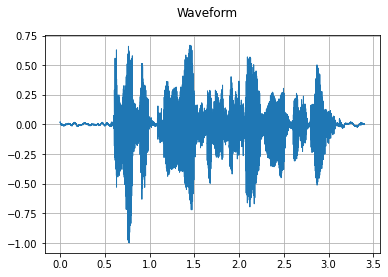

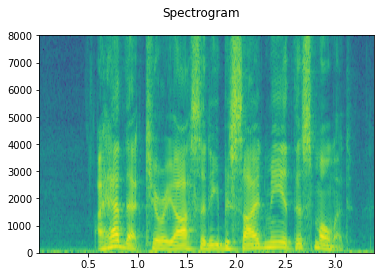

In [9]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

Loading from file-like object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


``torchaudio``\ 의 I/O 기능은 이제 파일과 유사한 객체를 지원합니다.  
이를 통해 로컬 파일 시스템 내부 및 외부 위치에서 오디오 데이터를 가져오고 디코딩할 수 있습니다.
다음 예는 이를 보여줍니다.




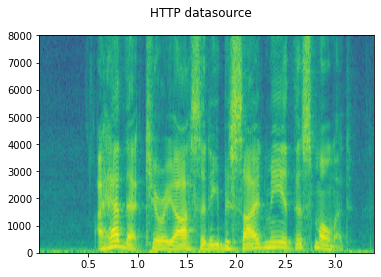

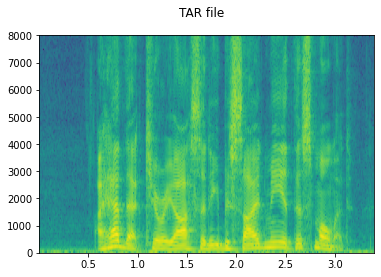

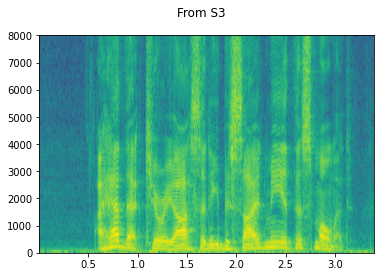

In [10]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

# Load audio from tar file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

# Load audio from S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

Tips on slicing
~~~~~~~~~~~~~~~

``num_frames`` 및 ``frame_offset`` 인수를 제공하면 디코딩이 입력의 해당 세그먼트로 제한됩니다.

바닐라 Tensor 슬라이싱을 사용하여 동일한 결과를 얻을 수 있습니다.
(즉, ``파형[:, frame_offset:frame_offset+num_frames]``). 그러나 ``num_frames`` 및 ``frame_offset`` 인수를 제공하는 것이 더 효율적입니다.

이는 요청된 프레임 디코딩이 완료되면 함수가 데이터 수집 및 디코딩을 종료하기 때문입니다. 필요한 양의 데이터를 가져오는 즉시 데이터 전송이 중지되므로 네트워크를 통해 오디오 데이터를 전송할 때 유리합니다.

다음 예는 이를 보여줍니다.




In [11]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

print("Fetching all the data...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform1, sample_rate1 = torchaudio.load(response.raw)
  waveform1 = waveform1[:, frame_offset:frame_offset+num_frames]
  print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform2, sample_rate2 = torchaudio.load(
      response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 65580 bytes
Checking the resulting waveform ... matched!


Saving audio to file
--------------------

To save audio data in formats interpretable by common applications,
you can use ``torchaudio.save``.

This function accepts a path-like object or file-like object.

When passing a file-like object, you also need to provide argument ``format``
so that the function knows which format it should use. In the
case of a path-like object, the function will infer the format from
the extension. If you are saving to a file without an extension, you need
to provide argument ``format``.

When saving WAV-formatted data, the default encoding for ``float32`` Tensor
is 32-bit floating-point PCM. You can provide arguments ``encoding`` and
``bits_per_sample`` to change this behavior. For example, to save data
in 16-bit signed integer PCM, you can do the following.

**Note** Saving data in encodings with lower bit depth reduces the
resulting file size but also precision.




In [12]:
waveform, sample_rate = get_sample()
print_stats(waveform, sample_rate=sample_rate)

# Save without any encoding option.
# The function will pick up the encoding which
# the provided data fit
path = "save_example_default.wav"
torchaudio.save(path, waveform, sample_rate)
inspect_file(path)

# Save as 16-bit signed integer Linear PCM
# The resulting file occupies half the storage but loses precision
path = "save_example_PCM_S16.wav"
torchaudio.save(
    path, waveform, sample_rate,
    encoding="PCM_S", bits_per_sample=16)
inspect_file(path)

Sample Rate: 44100
Shape: (1, 109368)
Dtype: torch.float32
 - Max:      0.508
 - Min:     -0.449
 - Mean:    -0.000
 - Std Dev:  0.122

tensor([[0.0027, 0.0063, 0.0092,  ..., 0.0032, 0.0047, 0.0052]])

----------
Source: save_example_default.wav
----------
 - File size: 437530 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=1, bits_per_sample=32, encoding=PCM_F)
----------
Source: save_example_PCM_S16.wav
----------
 - File size: 218780 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=1, bits_per_sample=16, encoding=PCM_S)


``torchaudio.save`` can also handle other formats. To name a few:




In [13]:
waveform, sample_rate = get_sample(resample=8000)

formats = [
  "mp3",
  "flac",
  "vorbis",
  "sph",
  "amb",
  "amr-nb",
  "gsm",
]

for format in formats:
  path = f"save_example.{format}"
  torchaudio.save(path, waveform, sample_rate, format=format)
  inspect_file(path)

----------
Source: save_example.mp3
----------
 - File size: 2664 bytes
 - AudioMetaData(sample_rate=8000, num_frames=21312, num_channels=1, bits_per_sample=0, encoding=MP3)
----------
Source: save_example.flac
----------
 - File size: 47315 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=24, encoding=FLAC)
----------
Source: save_example.vorbis
----------
 - File size: 9967 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=0, encoding=VORBIS)
----------
Source: save_example.sph
----------
 - File size: 80384 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=32, encoding=PCM_S)
----------
Source: save_example.amb
----------
 - File size: 79418 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=32, encoding=PCM_F)
----------
Source: save_example.amr-nb
----------
 - File size: 1618 bytes
 - AudioMetaData(sample_rate=8000, nu

Saving to file-like object
~~~~~~~~~~~~~~~~~~~~~~~~~~

Similar to the other I/O functions, you can save audio to file-like
objects. When saving to a file-like object, argument ``format`` is
required.




In [14]:
waveform, sample_rate = get_sample()

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFF\x12\xad\x06\x00WAVEfmt '
